In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from src.helpers import create_treemap_data
from src.data_loader import *

# Categories Structure

In [ ]:
df_categories = read_categories()
# Count artices with multiple categories
df_categories['article'].value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

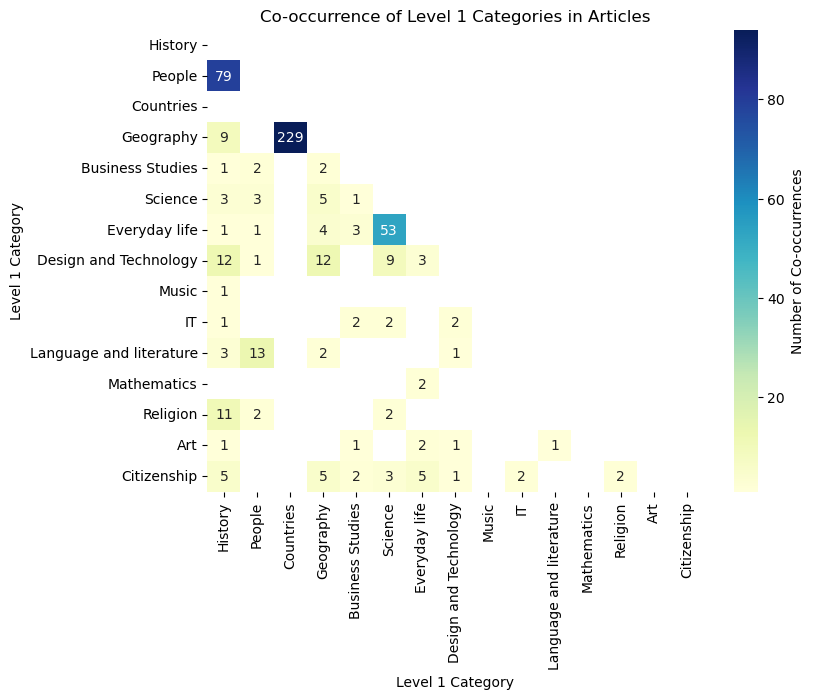

,Category Pair,Articles,Article Count
0,"(Geography, Countries)","[Åland, Éire, Abkhazia, Abu Dhabi, Afghanistan...",229
1,"(History, People)","[Áedán mac Gabráin, Óengus I of the Picts, Akh...",79
2,"(Science, Everyday life)","[Almond, Aquarium, Avocado, Barley, Basil, Bea...",53
3,"(People, Language and literature)","[Augusta, Lady Gregory, Benjamin Britten, Coll...",13
4,"(Design and Technology, History)","[Avro Lancaster, Castra, Colossus of Rhodes, F...",12


In [ ]:
# Step 1: Filter articles with multiple categories
multi_category_articles = df_categories.groupby('article').filter(lambda x: len(x) > 1)

# Step 2: Create pairs of category co-occurrences for each article with multiple categories
category_pairs = []
article_pairs = defaultdict(list)  # Dictionary to store articles for each unique category pair

for article in multi_category_articles['article'].unique():
    categories = multi_category_articles[multi_category_articles['article'] == article]['level_1'].unique()
    for pair in combinations(categories, 2):
        pair_set = frozenset(pair)  # Use a frozenset to ignore order
        category_pairs.append(pair_set)
        article_pairs[pair_set].append(article)  # Add the article to the respective pair list

# Step 3: Count the occurrences of each pair
pair_counts = Counter(category_pairs)

# Step 4: Convert pair_counts to a DataFrame for heatmap plotting
categories = df_categories['level_1'].unique()
heatmap_data = pd.DataFrame(0, index=categories, columns=categories)

# Step 5: Fill in the DataFrame with pair counts
for pair, count in pair_counts.items():
    cat1, cat2 = list(pair)
    heatmap_data.loc[cat1, cat2] = count
    heatmap_data.loc[cat2, cat1] = count  # Ensure symmetry

# Now, article_pairs contains each unique pair (unordered) with the list of associated articles

# Step 6: Plot the heatmap with a mask for the upper triangle, excluding zeros
mask = np.triu(np.ones_like(heatmap_data, dtype=bool)) | (heatmap_data == 0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", mask=mask,                      
            cbar_kws={'label': 'Number of Co-occurrences'}, fmt="g", robust=True)
plt.title("Co-occurrence of Level 1 Categories in Articles")
plt.xlabel("Level 1 Category")
plt.ylabel("Level 1 Category")
plt.show()

# Step 7: Convert article_pairs dictionary to a DataFrame with category pairs as sets and associated articles
article_pairs_df = pd.DataFrame([(pair, articles) for pair, articles in article_pairs.items()],
                                columns=['Category Pair', 'Articles'])

article_pairs_df['Article Count'] = article_pairs_df['Articles'].apply(len)  # Add count of articles
article_pairs_df = article_pairs_df.sort_values(by='Article Count', ascending=False).reset_index(drop=True)

# Display the DataFrame containing unique category pairs as sets and associated articles
article_pairs_df.head()

# Paths

In [11]:
df_finished = read_finished_paths()
df_unfinished = read_unfinished_paths()

In [ ]:
def build_network(df_paths, df_categories, include_self_loops=True):
    """
    Build a directed network graph from paths with main categories and edge weights.
    """
    # Map each article to its main category
    article_to_main_category = dict(zip(df_categories['article'], df_categories['level_1']))

    # Initialize directed graph
    G = nx.DiGraph()

    # Build the network with main categories and aggregate edge weights
    for path in df_paths['path']:
        nodes = path.split(';')
        # Map articles to their main categories
        main_category_nodes = [article_to_main_category.get(node, node) for node in nodes]

        for i in range(len(main_category_nodes) - 1):
            u = main_category_nodes[i]
            v = main_category_nodes[i + 1]
            if u != v or include_self_loops:
                # Add or update edge with weight
                if G.has_edge(u, v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u, v, weight=1)

    return G

def filter_network(G, weight_threshold=5, top_n=None):
    """
    Filter the network based on weight threshold and top connections.
    """
    # Apply weight threshold
    filtered_edges = [(u, v) for u, v, weight in G.edges(data='weight') if weight >= weight_threshold]
    H = G.edge_subgraph(filtered_edges).copy()

    # Limit each node to its top_n strongest connections, if specified
    if top_n is not None:
        for node in list(H.nodes):
            edges = sorted(H.edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)
            if len(edges) > top_n:
                edges_to_remove = edges[top_n:]
                H.remove_edges_from([(u, v) for u, v, _ in edges_to_remove])

    return H

def plot_network(H, title="Network Graph", node_size=700):
    """
    Plot the directed network graph with clear edge directions and weights.
    """
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(H, seed=42, k=0.5)  # Layout for consistent spacing
    plt.gca().set_facecolor("white")  # Set background to white

    # Draw nodes
    nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color="skyblue", edgecolors="black")
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight="bold")

    # Prepare edge attributes
    all_weights = [H[u][v]['weight'] for u, v in H.edges()]
    max_weight = max(all_weights) if all_weights else 1

    # Draw edges with arrowheads and edge labels
    edge_labels = {}
    for u, v in H.edges():
        weight = H[u][v]['weight']
        edge_width = min(weight / max_weight * 5, 5)  # Scale edge width based on weight

        # Draw edge with arrow
        nx.draw_networkx_edges(
            H, pos,
            edgelist=[(u, v)],
            width=edge_width,
            arrowstyle='-|>',
            arrowsize=15,
            edge_color='black',
            connectionstyle='arc3,rad=0.1' if H.has_edge(v, u) else 'arc3,rad=0.0'
        )

        # Prepare edge label with weight
        edge_labels[(u, v)] = f"{weight}"

    # Draw edge labels (weights)
    nx.draw_networkx_edge_labels(
        H, pos,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.5,
        bbox=dict(alpha=0),
        verticalalignment='center'
    )

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()

def analyze_edge_weights(G):
    """
    Analyze and plot the distribution of edge weights, and return statistical thresholds.
    """
    edge_weights = [weight for u, v, weight in G.edges(data='weight')]

    # Plot the distribution of edge weights
    plt.figure(figsize=(8, 6))
    plt.hist(edge_weights, bins=30, color="skyblue", edgecolor="black")
    plt.xlabel("Edge Weight")
    plt.ylabel("Frequency")
    plt.title("Distribution of Edge Weights")
    plt.show()

    # Calculate statistical thresholds
    mean_weight = np.mean(edge_weights)
    median_weight = np.median(edge_weights)
    percentile_75 = np.percentile(edge_weights, 75)
    percentile_90 = np.percentile(edge_weights, 90)

    print(f"Mean Weight: {mean_weight}")
    print(f"Median Weight: {median_weight}")
    print(f"75th Percentile: {percentile_75}")
    print(f"90th Percentile: {percentile_90}")

    return mean_weight, median_weight, percentile_75, percentile_90

def plot_network_with_thresholds(G, thresholds):
    """
    Plot the network for different weight thresholds for comparison.
    """
    for threshold in thresholds:
        H = filter_network(G, weight_threshold=threshold)
        
        # Visualize the graph for each threshold
        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(H, seed=42)
        nx.draw(H, pos, with_labels=True, node_size=500, font_size=10, edge_color="skyblue")
        plt.title(f"Graph with Weight Threshold = {threshold}")
        plt.show()

In [109]:
def normalize_edge_weights(G, df_categories):
    """
    Normalize edge weights by the number of articles in the source category.
    """
    # Count articles per category
    category_counts = df_categories['level_1'].value_counts().to_dict()

    # Create a copy of the graph for normalized weights
    G_normalized = G.copy()

    # Normalize edge weights
    for u, v, data in G.edges(data=True):
        source_count = category_counts.get(u, 1)  # Default to 1 if category count not available
        normalized_weight = data['weight'] / source_count
        G_normalized[u][v]['weight'] = normalized_weight

    return G_normalized

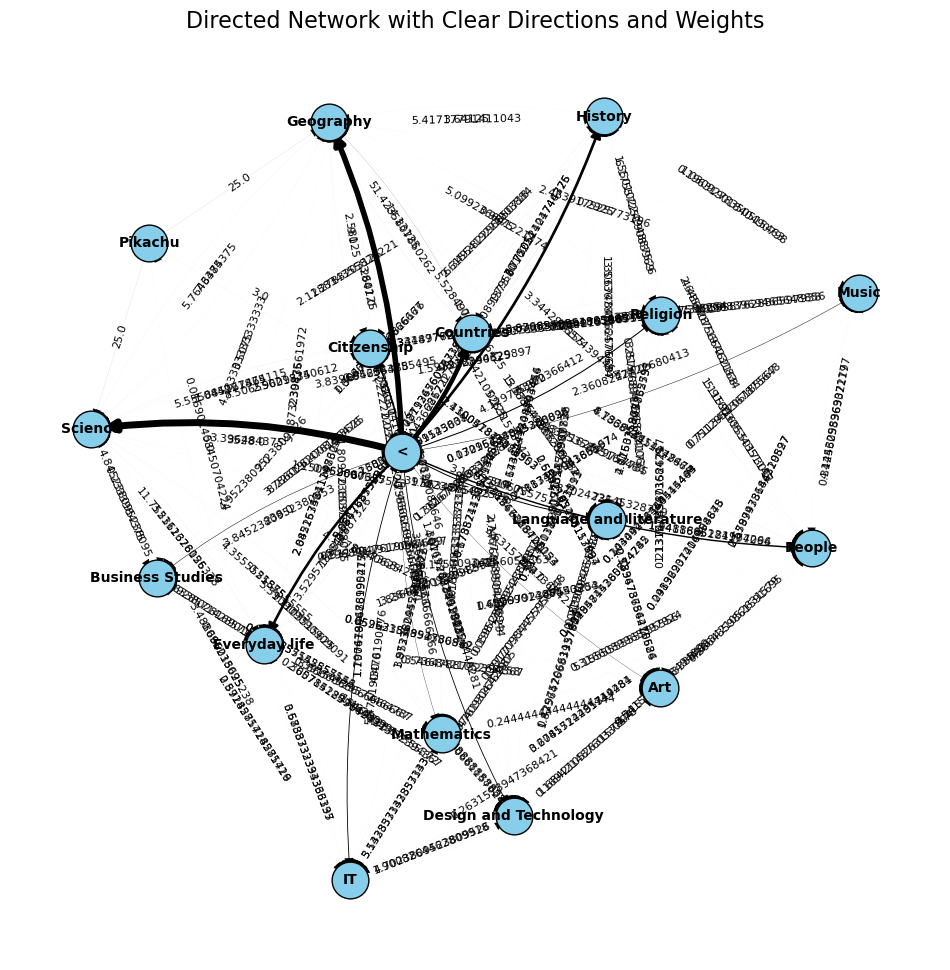

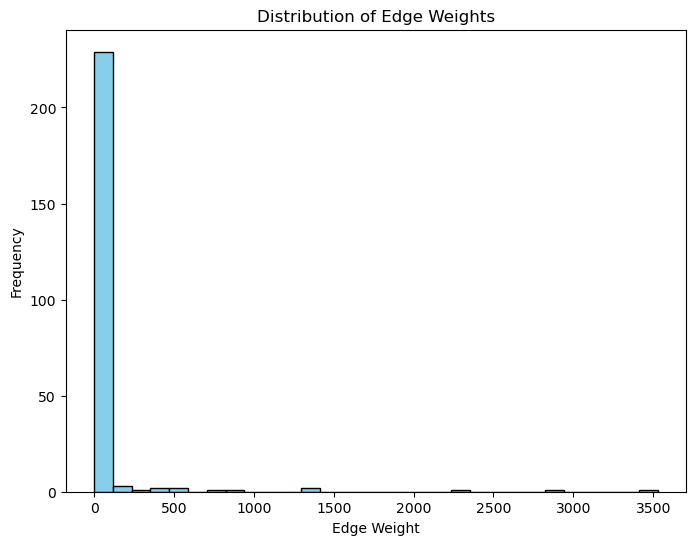

Mean Weight: 66.74306378620963
Median Weight: 1.9206513183785912
75th Percentile: 4.223471741637831
90th Percentile: 9.039737991266376


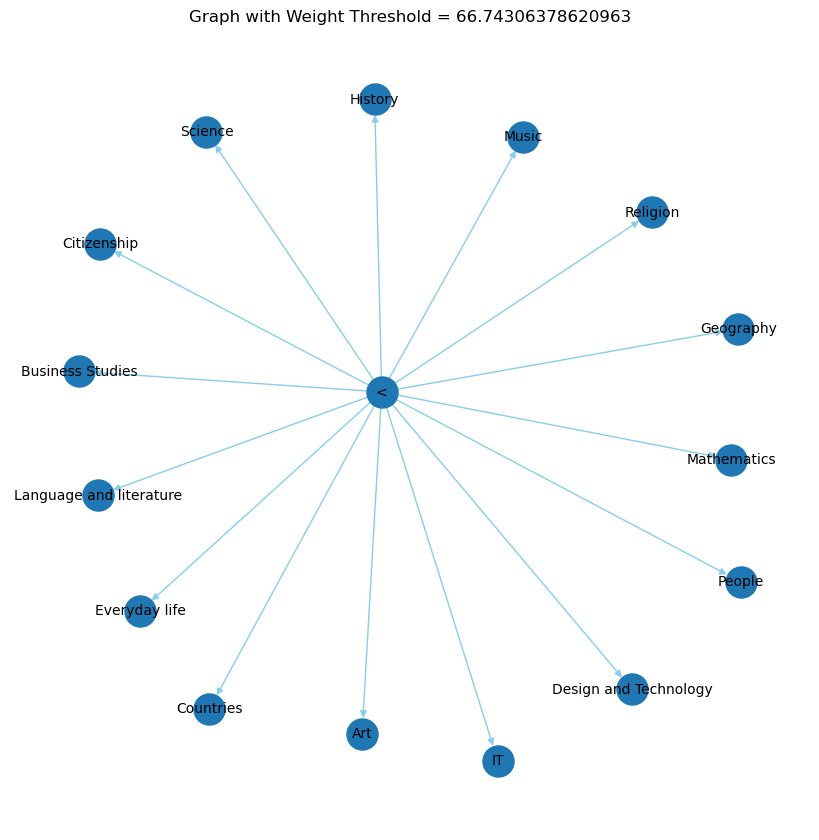

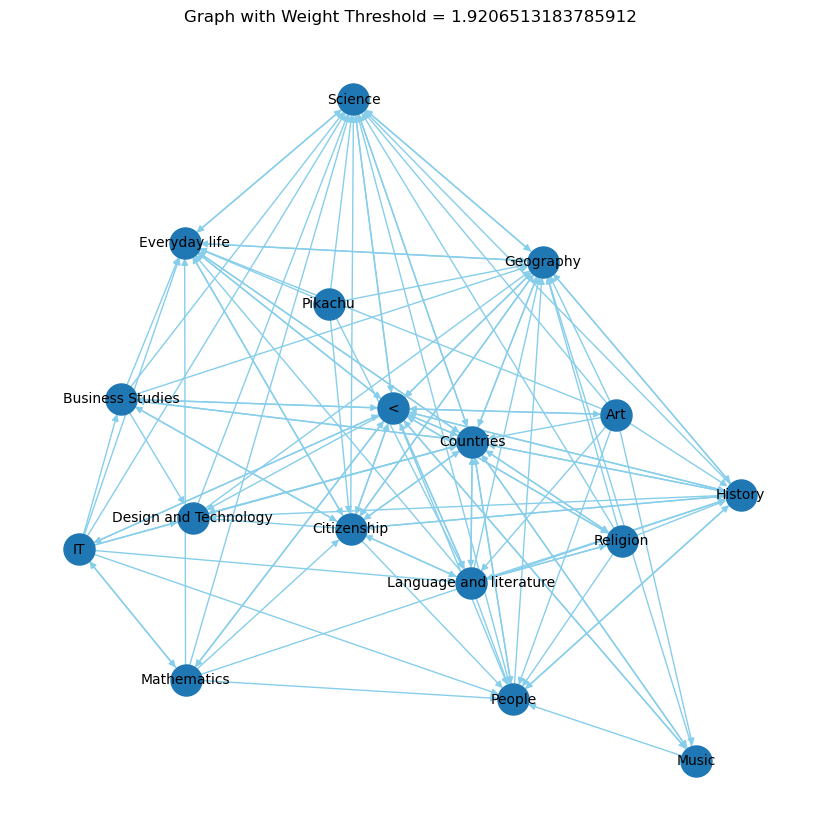

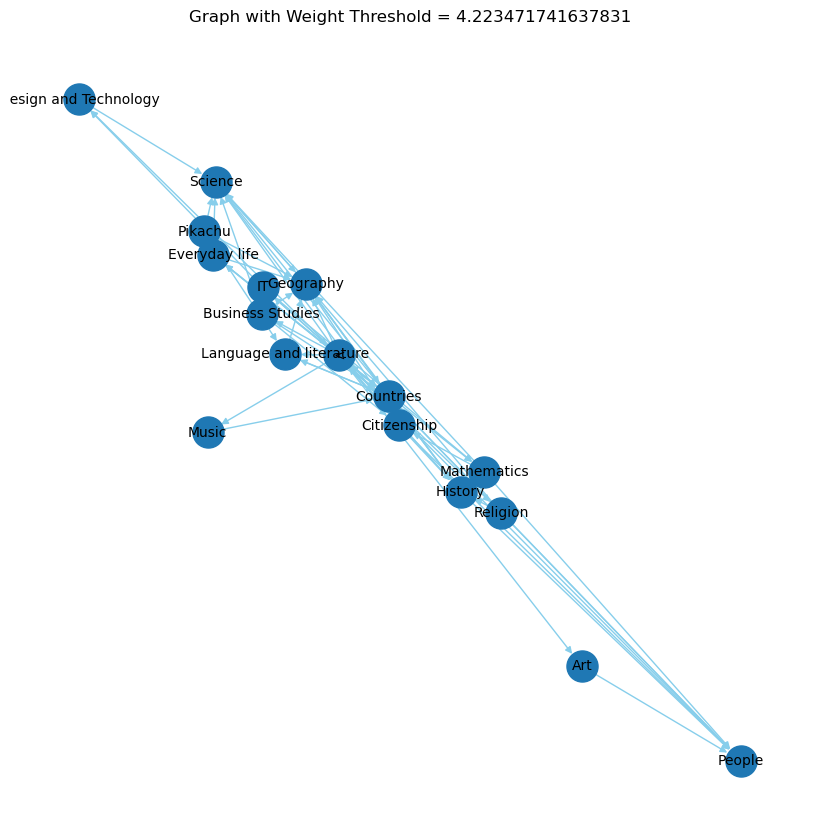

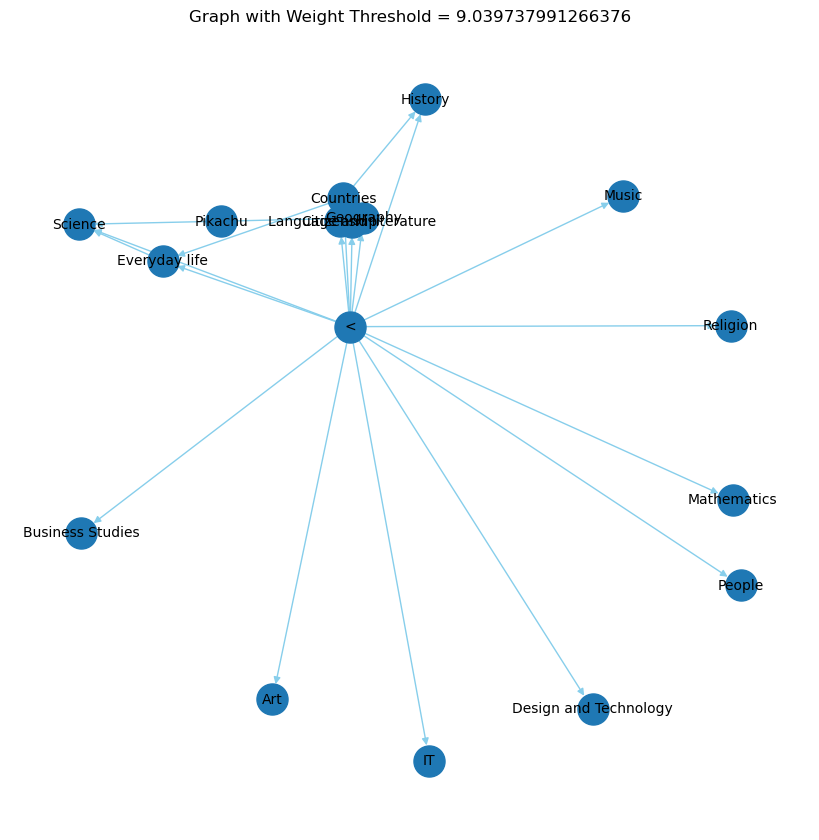

In [131]:
# Build the network including self-loops to capture intra-category transitions
G = build_network(df_finished, df_categories_filtered, include_self_loops=False)

# Example usage:
G_normalized = normalize_edge_weights(G, df_categories_filtered)

# Filter the network based on a chosen weight threshold
H = filter_network(G_normalized, weight_threshold=0, top_n=None)

# Plot the network with clear edge directions and edge labels
plot_network(H, title="Directed Network with Clear Directions and Weights")

# Step 3: Analyze edge weights and get thresholds (if want to explore different thresholds)
mean_weight, median_weight, percentile_75, percentile_90 = analyze_edge_weights(H)
plot_network_with_thresholds(H, [mean_weight, median_weight, percentile_75, percentile_90])

In [132]:
def get_top_edges(G, top_n=10):
    """
    Get the top N edges with the highest weights.
    """
    edges = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]
    top_edges = sorted(edges, key=lambda x: x[2], reverse=True)[:top_n]
    df_top_edges = pd.DataFrame(top_edges, columns=['Source', 'Target', 'Weight'])
    return df_top_edges

# Example usage:
top_edges = get_top_edges(G_normalized, top_n=40)
print("Top 20 Transitions Between Categories:")
print(top_edges)

Top 20 Transitions Between Categories:
                     Source                   Target       Weight
0                         <                  Science  3528.000000
1                         <                Geography  2847.000000
2                         <                Countries  2267.000000
3                         <                  History  1373.000000
4                         <            Everyday life  1338.000000
5                         <              Citizenship   863.000000
6                         <                   People   735.000000
7                         <                 Religion   533.000000
8                         <  Language and literature   514.000000
9                         <                       IT   430.000000
10                        <    Design and Technology   421.000000
11                        <         Business Studies   238.000000
12                        <                    Music   227.000000
13                        <          

In [133]:
def compute_node_degrees(G):
    """
    Compute in-degree and out-degree for each node.
    """
    degrees = []
    for node in G.nodes():
        in_deg = G.in_degree(node)
        out_deg = G.out_degree(node)
        degrees.append({'Category': node, 'In-Degree': in_deg, 'Out-Degree': out_deg})
    df_degrees = pd.DataFrame(degrees)
    return df_degrees

# Example usage:
node_degrees = compute_node_degrees(G_normalized)
print("Node Degrees:")
print(node_degrees.sort_values(by='In-Degree', ascending=False).head(10))


Node Degrees:
                   Category  In-Degree  Out-Degree
3               Citizenship         16          15
5                   Science         16          15
7             Everyday life         16          16
1                 Geography         16          15
11  Language and literature         16          15
0                   History         15          15
10    Design and Technology         15          15
14                       IT         15          14
13         Business Studies         15          15
12                    Music         15          15


In [134]:
def compute_centrality_measures(G):
    """
    Compute betweenness centrality for each node.
    """
    betweenness = nx.betweenness_centrality(G, weight='weight')
    df_betweenness = pd.DataFrame(list(betweenness.items()), columns=['Category', 'Betweenness Centrality'])
    return df_betweenness

# Example usage:
centrality = compute_centrality_measures(G_normalized)
print("Top Categories by Betweenness Centrality:")
print(centrality.sort_values(by='Betweenness Centrality', ascending=False).head(10))


Top Categories by Betweenness Centrality:
                   Category  Betweenness Centrality
12                    Music                0.408333
13         Business Studies                0.287500
9                       Art                0.204167
15              Mathematics                0.195833
4                  Religion                0.137500
10    Design and Technology                0.112500
14                       IT                0.100000
3               Citizenship                0.062500
7             Everyday life                0.062500
11  Language and literature                0.033333


In [135]:
def edge_weight_statistics(G):
    """
    Compute statistical summary of edge weights.
    """
    edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]
    stats = {
        'Count': len(edge_weights),
        'Mean': np.mean(edge_weights),
        'Median': np.median(edge_weights),
        'Standard Deviation': np.std(edge_weights),
        'Min': np.min(edge_weights),
        'Max': np.max(edge_weights),
        '25th Percentile': np.percentile(edge_weights, 25),
        '75th Percentile': np.percentile(edge_weights, 75),
    }
    df_stats = pd.DataFrame.from_dict(stats, orient='index', columns=['Edge Weight Statistics'])
    return df_stats

# Example usage:
edge_stats = edge_weight_statistics(G_normalized)
print("Edge Weight Statistics:")
print(edge_stats)


Edge Weight Statistics:
                    Edge Weight Statistics
Count                           244.000000
Mean                             66.743064
Median                            1.920651
Standard Deviation              354.301319
Min                               0.016901
Max                            3528.000000
25th Percentile                   0.630103
75th Percentile                   4.223472


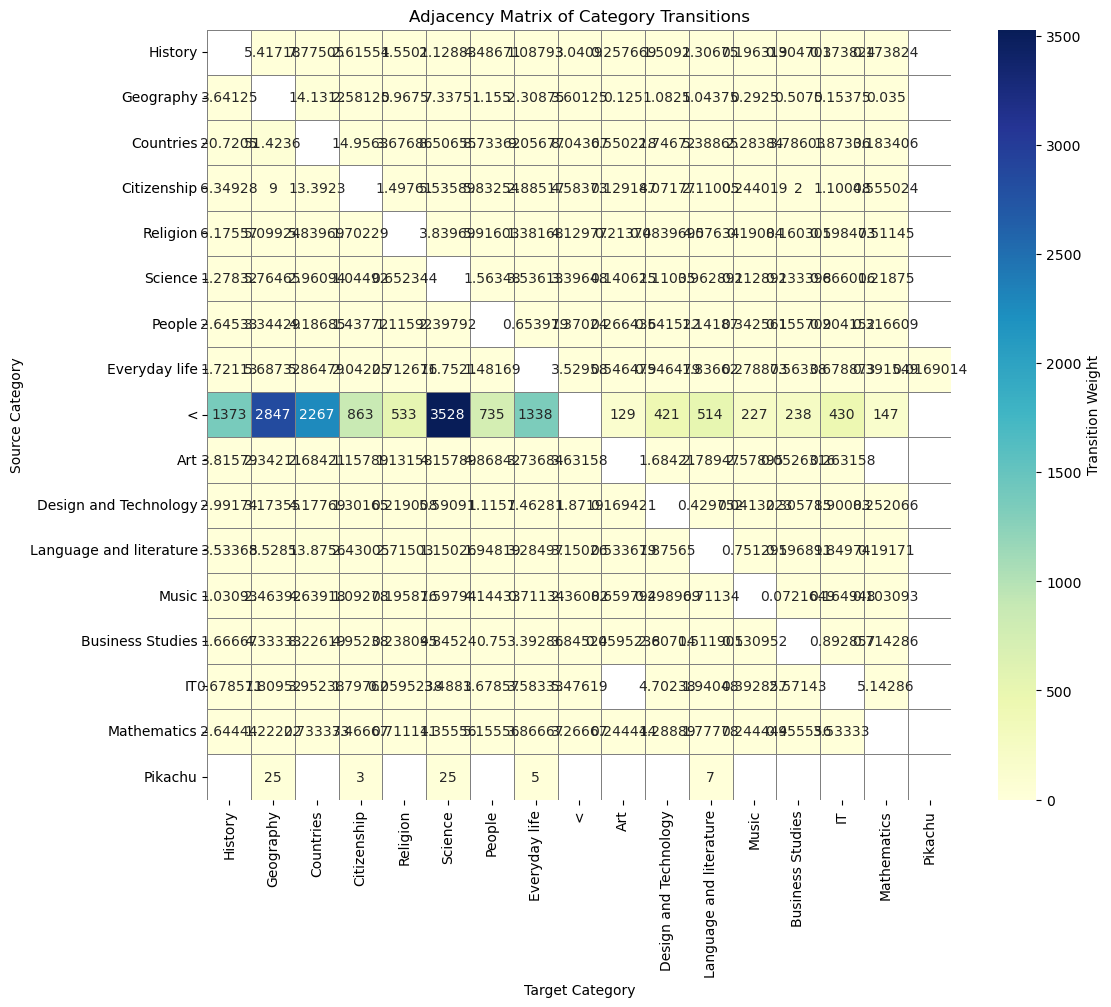

In [136]:
def create_adjacency_matrix(G):
    """
    Create an adjacency matrix of the graph.
    """
    adjacency_matrix = nx.to_pandas_adjacency(G, weight='weight')
    return adjacency_matrix

# Example usage
adj_matrix = create_adjacency_matrix(G_normalized)

# Plot the adjacency matrix
plt.figure(figsize=(12, 10))
# Create a mask for zero values
mask = adj_matrix == 0
# Plot with a diverging color map and mask for zero values
sns.heatmap(adj_matrix, cmap='YlGnBu', mask=mask, annot=True, fmt='g', cbar_kws={'label': 'Transition Weight'},
            linewidths=0.5, linecolor='grey', vmin=adj_matrix.values.min(), vmax=adj_matrix.values.max())
plt.title("Adjacency Matrix of Category Transitions")
plt.xlabel("Target Category")
plt.ylabel("Source Category")
plt.show()


In [137]:
import community as community_louvain

def detect_communities(G):
    """
    Detect communities in the network using the Louvain method.
    """
    partition = community_louvain.best_partition(G.to_undirected(), weight='weight')
    df_partition = pd.DataFrame(list(partition.items()), columns=['Category', 'Community'])
    return df_partition

# Example usage:
communities = detect_communities(G_normalized)
print("Communities Detected:")
communities.sort_values(by='Community')


Communities Detected:


,Category,Community
0,History,0
7,Everyday life,0
5,Science,0
4,Religion,0
8,<,0
2,Countries,0
1,Geography,0
3,Citizenship,0
6,People,1
15,Mathematics,1


In [ ]:
# Merge with node degrees or centrality measures for further analysis
node_degrees_with_communities = node_degrees.merge(communities, on='Category')

def analyze_paths(df_paths, df_categories, omit_loops=False):
    """
    Analyze the paths to compute statistics and find common paths.
    Optionally omit consecutive repetitions of the same category in paths.
    """
    # Map articles to main categories
    article_to_category = dict(zip(df_categories['article'], df_categories['level_1']))
    
    path_lengths = []
    category_paths = []
    path_counts = {}
    
    for path in df_paths['path']:
        articles = path.split(';')
        categories = [article_to_category.get(article, article) for article in articles]

        # Remove consecutive duplicate categories if omit_loops is True
        if omit_loops:
            categories = [category for i, category in enumerate(categories) 
                          if i == 0 or category != categories[i - 1]]

        # Create a string representation of the category path
        category_path = ' -> '.join(categories)
        path_lengths.append(len(categories))
        category_paths.append(category_path)
        
        # Count path occurrences
        if category_path in path_counts:
            path_counts[category_path] += 1
        else:
            path_counts[category_path] = 1
    
    # Add new columns to the original dataframe
    df_paths['Category Path'] = category_paths
    df_paths['Path Length'] = path_lengths
    
    # Path length statistics
    path_length_stats = {
        'Average Path Length': np.mean(path_lengths),
        'Median Path Length': np.median(path_lengths),
        'Max Path Length': np.max(path_lengths),
        'Min Path Length': np.min(path_lengths),
    }
    
    # Most common paths
    sorted_paths = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)
    df_common_paths = pd.DataFrame(sorted_paths[:20], columns=['Category Path', 'Count'])
    
    return df_paths, path_length_stats, df_common_paths

# Example usage:
df_paths_analyzed, path_length_stats, common_paths = analyze_paths(df_finished, df_categories_filtered, omit_loops=True)
print("Path Length Statistics:")
print(path_length_stats)
print("\nMost Common Category Paths:")
common_paths.to_csv("common_paths.csv", index=False)
common_paths


Path Length Statistics:
{'Average Path Length': 4.655910206944932, 'Median Path Length': 4.0, 'Max Path Length': 264, 'Min Path Length': 1}

Most Common Category Paths:


,Category Path,Count
0,Science,1194
1,Geography -> Science,568
2,Geography -> Countries -> Geography,402
3,Science -> Geography,371
4,Science -> Geography -> Science,364
5,Everyday life -> Science,332
6,Geography -> Countries,300
7,Geography,272
8,Science -> Geography -> Countries,267
9,Science -> Geography -> Countries -> History,260


In [128]:
def correlation_analysis(G):
    """
    Analyze correlation between edge weights and degrees of source and target nodes.
    """
    data = []
    for u, v, data_uv in G.edges(data=True):
        weight = data_uv['weight']
        out_deg_u = G.out_degree(u)
        in_deg_v = G.in_degree(v)
        data.append({
            'Source': u,
            'Target': v,
            'Weight': weight,
            'Source Out-Degree': out_deg_u,
            'Target In-Degree': in_deg_v
        })
    df_edge_analysis = pd.DataFrame(data)
    correlation = df_edge_analysis['Weight'].corr(df_edge_analysis['Source Out-Degree'])
    print(f"Correlation between Edge Weight and Source Out-Degree: {correlation}")
    correlation = df_edge_analysis['Weight'].corr(df_edge_analysis['Target In-Degree'])
    print(f"Correlation between Edge Weight and Target In-Degree: {correlation}")
    return df_edge_analysis

# Example usage:
edge_analysis_df = correlation_analysis(G_normalized)


Correlation between Edge Weight and Source Out-Degree: 0.026045559742904553
Correlation between Edge Weight and Target In-Degree: 0.04372917651172352


In [129]:
from scipy.stats import powerlaw, kstest

def test_power_law_distribution(G):
    """
    Test if the edge weight distribution follows a power-law distribution.
    """
    edge_weights = np.array([data['weight'] for u, v, data in G.edges(data=True)])
    normalized_weights = edge_weights / edge_weights.sum()
    params = powerlaw.fit(normalized_weights)
    D, p_value = kstest(normalized_weights, 'powerlaw', args=params)
    print(f"Kolmogorov-Smirnov test D-statistic: {D}, p-value: {p_value}")

# Example usage:
test_power_law_distribution(G_normalized)


Kolmogorov-Smirnov test D-statistic: 0.410267719336289, p-value: 4.294360071138146e-40


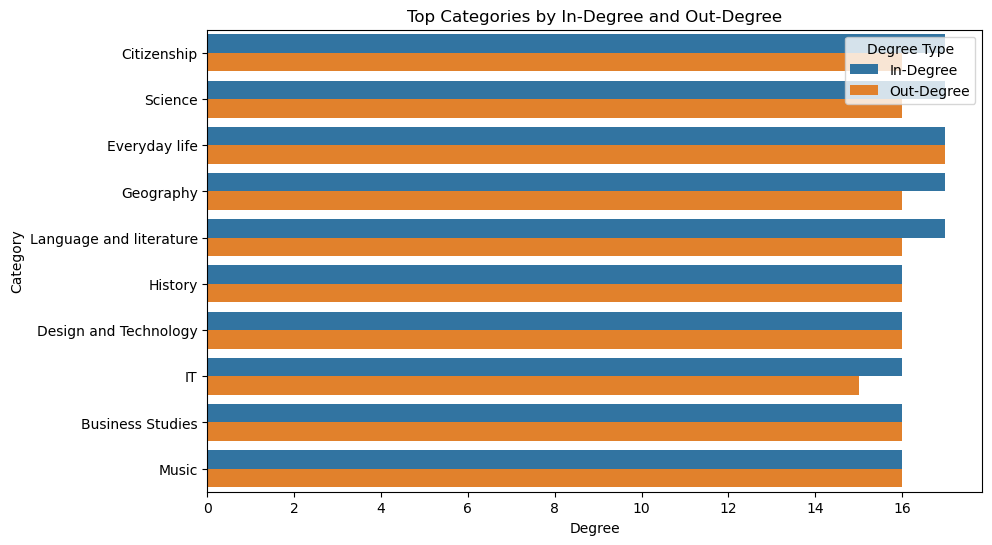

In [130]:
def plot_top_in_out_degrees(df_degrees, top_n=10):
    """
    Plot the top N categories by both in-degree and out-degree in the same plot.
    """
    # Select the top N categories based on In-Degree
    top_categories = df_degrees.sort_values(by='In-Degree', ascending=False).head(top_n)
    
    # Reshape the data to a long format for plotting both In-Degree and Out-Degree
    top_categories_long = top_categories.melt(id_vars='Category', 
                                              value_vars=['In-Degree', 'Out-Degree'],
                                              var_name='Degree Type', 
                                              value_name='Degree')
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Degree', y='Category', hue='Degree Type', data=top_categories_long)
    plt.title('Top Categories by In-Degree and Out-Degree')
    plt.xlabel('Degree')
    plt.ylabel('Category')
    plt.legend(title='Degree Type')
    plt.show()

# Example usage:
plot_top_in_out_degrees(node_degrees)